# INVESTIGATING THE EFFECT OF TRANSFER LEARNING, TRAINING SET SIZE, AND TARGET TASK ON TEST CLASSIFICATION ACCURACY

In [2]:
import glob, os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from nltools.data import Brain_Data
from torch.utils.data import DataLoader
from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.tools import ToTensor, compute_accuracy
from delphi.utils.plots import confusion_matrix
from delphi.utils.datasets import NiftiDataset
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_recall_curve
from tqdm.notebook import tqdm

/home/philippseidel/anaconda3/envs/thesis-env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
DEVICE = torch.device("cpu")
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
classes_of_ds = {
    'MOTOR': sorted(['handleft', 'handright', 'footleft', 'footright', 'tongue']),
    'GAMBLING': sorted(['reward', 'loss']),
    'SOCIAL': sorted(['mental', 'random']),
    'WM': sorted(['body', 'face', 'place', 'tool']),
    'RELATIONAL': sorted(['match', 'relation']),
    'EMOTION': sorted(['emotion', 'neut']),
    'LANGUAGE': ['story', 'math'],
}

In [5]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Helper functions

In [6]:
def concat_stat_files(folds, file):
    '''
    '''
    df_list = []
    for f, fold in enumerate(folds):
        
        df_list.append(pd.read_csv(os.path.join(fold, file)))
        
    combined = pd.concat(df_list)
    
    return combined
        

In [7]:
def get_test_stats(path_to_model, data, class_labels, overwrite=False) -> tuple:
    '''
    '''
    
    stats_file = os.path.join(path_to_model, "test_stats.csv")
    if os.path.isfile(stats_file) and not overwrite:
        stats_df = pd.read_csv(stats_file)
        
    else:
        model = BrainStateClassifier3d(path_to_model)

        with torch.no_grad():
            _, stats = model.fit(data, train=False)


        stats_df = pd.DataFrame(stats.tolist(), columns=[*class_labels, *["real", "predicted"]])
        stats_df.to_csv(os.path.join(path_to_model, "test_stats.csv"), index=False)   
    
    return stats_df

# Analyze source networks

In this study, we want to investigate to what extend different "training approaches", "training sample sizes", and "target tasks" have on classification accuracies in 3D convolutional neural networks. 

To this end, we used data from 160 subjects of the Human Connectome Project (HCP). The participants were scanned while performing a multitude of cognitive tasks. The umbrella terms for these tasks are Motor, Emotion, Working Memory, Language, Social, Relational, and Gambling. Each of these tasks has multiple conditions within it, e.g., moving the left/right feet or hands, or the tongue in the Motor task. 


We will look at how our source networks trained in a leave-one-task out approach perform. 
We will check out:

* the training and validation loss and accuracy curves
* the performance on the test split
* the across fold average confusion matrices

In [8]:
left_out_tasks = sorted(["motor", "wm", "emotion", "language", "social", "relational", "gambling"])

path_to_nets = "./models/source-nets"
path_to_test_data = "../t-maps/test/"

## Plot train and validation losses and accuracies

What we expect to see:

* the loss curves for the training and validation set should trend towards zero
* if the validation loss curves increases after a certain epoch we have overfitting

* the accuracy curves should approach, in the best of all worlds, 1
* the accuracy curve of the training set is generally closer to 1 than for the validation set. We hope for small discrepancies between the two lines

Problems and solutions:

* if the validation loss increases after a while, we can still be certain that we use the best performing model that has not yet overfitted because we save only the state_dict of the model with the highest accuracy and smalles loss

Observations:
After running the below cell you should see a 7-by-2 graph. The columns represent the loss curves (left) and the accuracy curves (right). The rows represent the networks trained on all but one task.
The blue lines depict the evolution of the loss/accuracy curve for the training set, whereas the orange dashed line represents the curves for the validation set.

We can see see the same pattern for each of the networks, in that the loss curves for the training set get closer to zero with each epoch. However, we also observe that at around the 10th epoch the validation loss appears to increase, suggesting overfitting at this point. 
The accuracy curves are as expected.

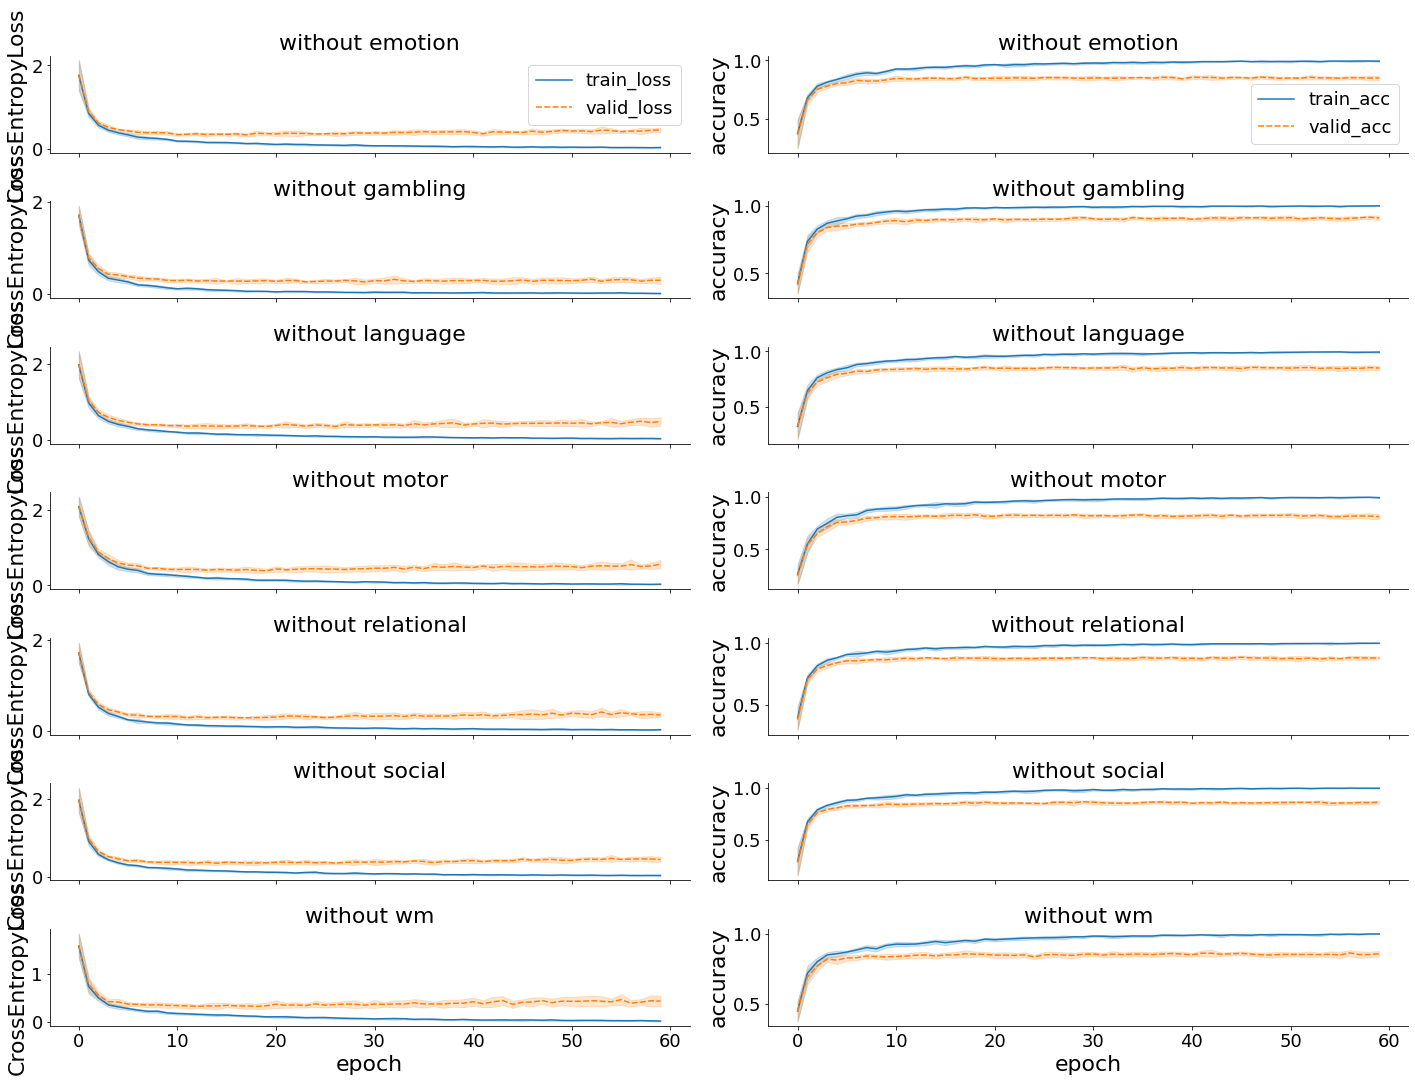

In [9]:
fig, axes = plt.subplots(len(left_out_tasks), 2, figsize=(20, 15), sharex=True)

for t, task in enumerate(left_out_tasks):

    if t == 0:
        plt_legend=True
    else:
        plt_legend=False
    
    # get the labels for the dataloader
    tmp = [value for key, value in classes_of_ds.items() if key not in {task.upper()}]
    class_labels = [j for val in tmp for j in val]

    
    # get all folds
    folds = sorted(glob.glob(os.path.join(path_to_nets, f"*{task}*")))
    curves = concat_stat_files(folds, "loss_acc_curves.csv")

    sns.lineplot(ax=axes[t, 0], data=curves[["train_loss", "valid_loss"]], errorbar=("sd"), n_boot=None, legend=plt_legend)
    axes[t, 0].set_ylabel("CrossEntropyLoss")
    sns.lineplot(ax=axes[t, 1], data=curves[["train_acc", "valid_acc"]], errorbar=("sd"), n_boot=None, legend=plt_legend)
    axes[t, 1].set_ylabel("accuracy")
    for i in range(2):
        axes[t, i].set_title(f"without {task}")
        axes[t, i].set_xlabel("epoch")
        axes[t, i].spines["right"].set_visible(False), axes[t, i].spines["top"].set_visible(False)

fig.tight_layout()

## Show the test split classification accuracies

We now turn to investigate the network performances on the left out test dataset. These accuracy scores are actually what we are most interested in. 
If these scores are bad, we can be quite certain, that our networks simply learned the idiosyncracies of the training set.

For further research we also check which of the 10 folds for each condition (i.e., the left out task) performed the best.

What we would hope to see in this analysis is that, on average, the networks do not perform differently. However, since we have different numbers of classes to predict for some of the networks, we can at least expect minor differences. 

In [10]:
#path_to_nets = "./models/from-scratch"
path_to_nets = "./models/source-nets"
#target_task = ["motor", "wm", "emotion", "social", "relational", "gambling", "language"]
target_task = sorted(["motor", "wm", "emotion", "social", "relational", "language", "gambling"])
stats = {}
accs = np.zeros((10, len(target_task)))

for t, task in enumerate(target_task):

    tmp = [value for key, value in classes_of_ds.items() if key not in {task.upper()}]
    class_labels = [j for val in tmp for j in val]
    
    # get all folds
    folds = sorted(glob.glob(os.path.join(path_to_nets, f"*{task}*")))

    # get the test data
    test_data = DataLoader(NiftiDataset(path_to_test_data, class_labels, 0, device=DEVICE, transform=ToTensor()),
                          batch_size=32, shuffle=False)

    stats[task] = []
    
    for f, fold in enumerate(folds):
        stats[task].append(get_test_stats(fold, test_data, class_labels))
        accs[f, t] = compute_accuracy(stats[task][f]["real"], stats[task][f]["predicted"])

df_source_accs = pd.DataFrame(accs.tolist(), columns=target_task)

In [11]:
print(df_source_accs)
df_source_accs.to_csv("./stats/source-nets-accs.csv", index=False)

    emotion  gambling  language     motor  relational    social        wm
0  0.870588  0.914706  0.891176  0.846429    0.908824  0.870588  0.876667
1  0.867647  0.923529  0.882353  0.842857    0.905882  0.888235  0.890000
2  0.876471  0.923529  0.905882  0.846429    0.911765  0.897059  0.893333
3  0.852941  0.905882  0.888235  0.853571    0.905882  0.870588  0.906667
4  0.870588  0.926471  0.870588  0.850000    0.885294  0.870588  0.900000
5  0.885294  0.926471  0.879412  0.853571    0.914706  0.882353  0.896667
6  0.900000  0.938235  0.902941  0.839286    0.905882  0.861765  0.916667
7  0.897059  0.950000  0.923529  0.853571    0.888235  0.873529  0.900000
8  0.870588  0.911765  0.894118  0.850000    0.917647  0.905882  0.920000
9  0.864706  0.941176  0.891176  0.835714    0.888235  0.891176  0.913333


Based on this matrix we can now identify the best performing fold per column.

In [12]:
best_fold = df_source_accs.idxmax()
print(best_fold)

emotion       6
gambling      7
language      7
motor         3
relational    8
social        8
wm            8
dtype: int64


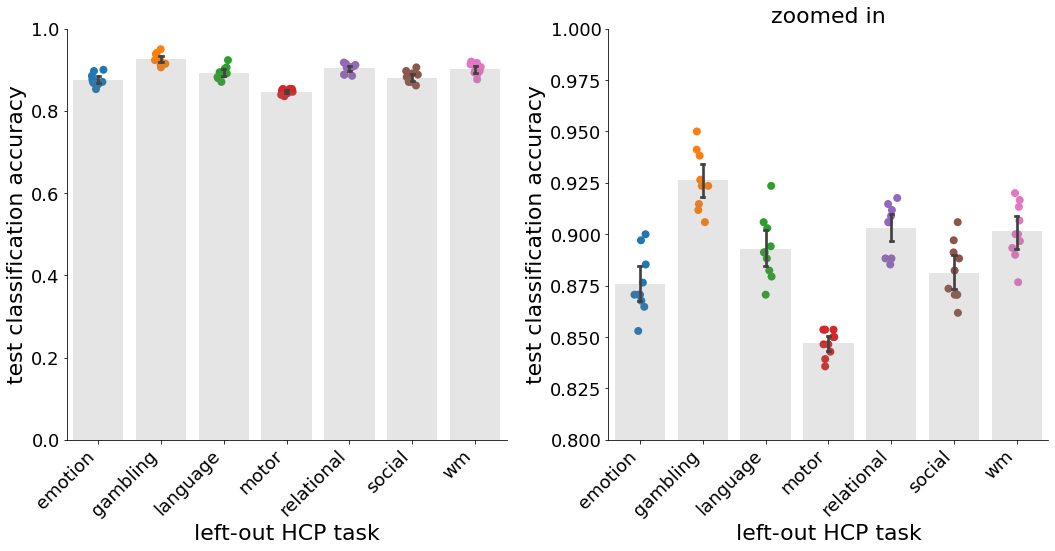

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

sns.stripplot(ax=axes[0], data=df_source_accs, size=8, zorder=1)
sns.barplot(ax=axes[0], data=df_source_accs, errorbar=("ci", 95), capsize=.05, color=.5*np.ones(3), alpha=.2)
axes[0].set_ylim([0, 1])
sns.stripplot(ax=axes[1], data=df_source_accs, size=8, zorder=1)
sns.barplot(ax=axes[1], data=df_source_accs, errorbar=("ci", 95), capsize=.05, color=.5*np.ones(3), alpha=.2)
axes[1].set_ylim([.8, 1])
axes[1].set_title("zoomed in")

for i in range(2):
    axes[i].set_xlabel("left-out HCP task");
    axes[i].set_ylabel("test classification accuracy");
    axes[i].set_xticklabels(left_out_tasks, rotation=45, ha="right")
    axes[i].spines['top'].set_visible(False), axes[i].spines['right'].set_visible(False);

fig.tight_layout()

From the test accuracies in the graph above we see that all networks (and folds) perform reliably above the chance level. However, we can see that there are differences in test classification performance as high as 7.25% (see gambling vs. motor).
It seems that leaving out the classes of the motor reduces test classification performance the most. 

Confusion matrices or ROC curves may help us better understand why these accuracy drops occur. 

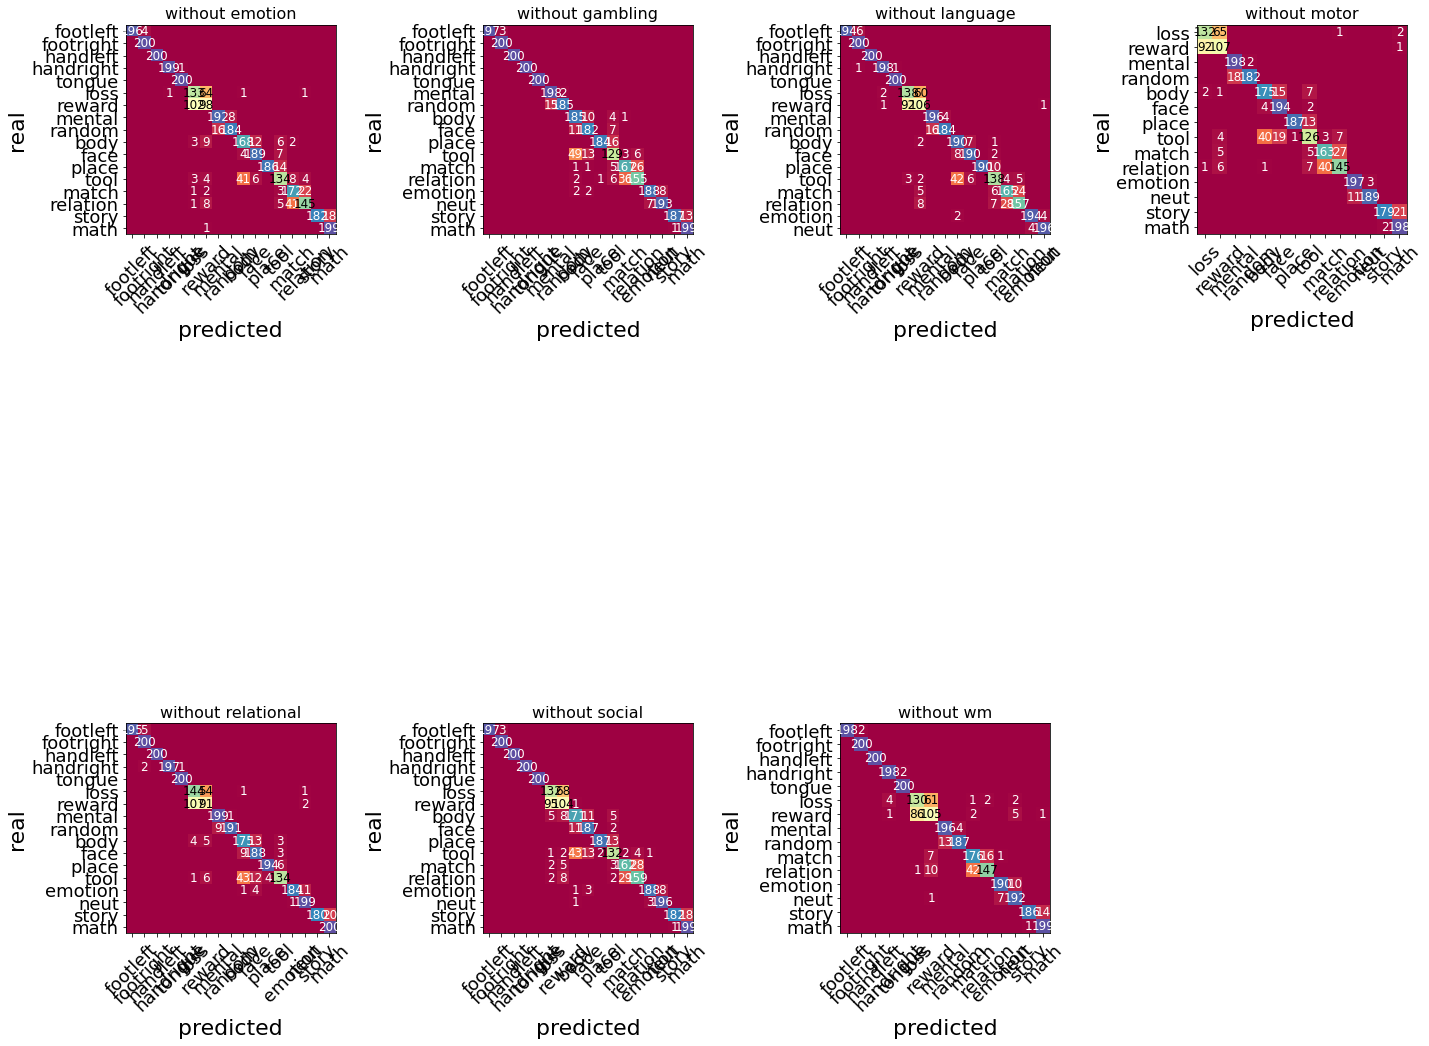

In [14]:
# confusion matrices across all folds
fig, axes = plt.subplots(2, 4, figsize=(20,20))
fig.axes[-1].remove()
# compute and plot confusion matrices
for i, ax in enumerate(axes.flat[:-1]):
    
    # first concat the stat dataframes
    df = pd.concat(stats[target_task[i]])
    
    # compute the confusion matrix and plot it
    _ = confusion_matrix(df["real"], df["predicted"], df.columns[:-2], ax=ax)

    ax.set_title(f'without {target_task[i]}')

fig.tight_layout()

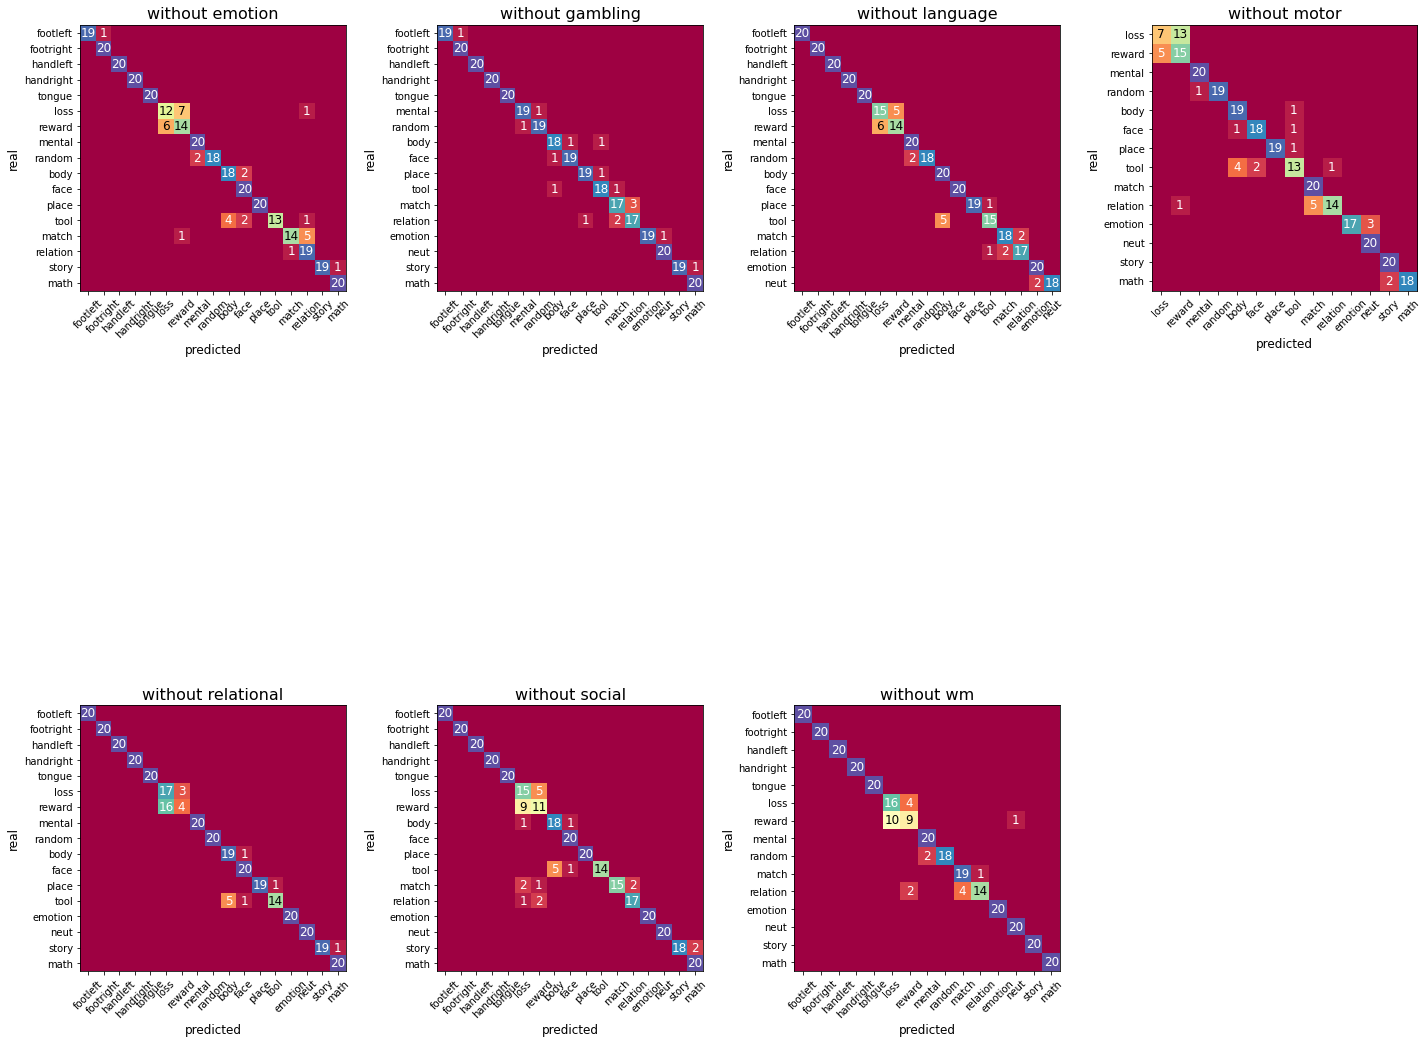

In [15]:
# confusion matrices for the best performing fold
fig, axes = plt.subplots(2, 4, figsize=(20,20))
fig.axes[-1].remove()
# compute and plot confusion matrices
for i, ax in enumerate(axes.flat[:-1]):
    df = stats[target_task[i]][best_fold[target_task[i]]]
    _ = confusion_matrix(df["real"], df["predicted"], df.columns[:-2], ax=ax)
    ax.set_title(f'without {target_task[i]}')
    
fig.tight_layout()

The group and the best-fold confusion matrices suggest that the conditions of the gambling task (loss and reward) can not be reliably classified. 
Other culprits of lower test classification accuracy appear to be the "body" and "tool" condition of the working memory task, as well as the "match" and "relation" conditions. 

# Checking the performance of networks trained "from scratch" vs pretrained

In [18]:
#path_to_nets = "./models/from-scratch"
path_to_nets = "./models/from-scratch"
target_task = sorted(["motor", "wm", "emotion", "social", "relational", "gambling", "language"])
#target_task = ["motor", "wm", "emotion", "social", "relational", "language"]
#target_task = ["relational"]
sample_sizes = [10, 25, 50, 75, 120]
accs = np.zeros((20, 5, len(target_task)))

for t, task in enumerate(target_task):

    # get the labels for the dataloader
    class_labels = classes_of_ds[task.upper()]

    
    for s, sample_size in enumerate(sample_sizes):
        # get all folds
        folds = sorted(glob.glob(os.path.join(path_to_nets, f"*{task}*{sample_size}*")))

        # get the test data
        test_data = DataLoader(NiftiDataset(path_to_test_data, class_labels, 0, device=DEVICE, transform=ToTensor()),
                              batch_size=32, shuffle=False)

        #conf_mats[task] = np.zeros((len(class_labels), len(class_labels), len(folds)))

        for f, fold in enumerate(folds):

            stats = get_test_stats(fold, test_data, class_labels)
            accs[f, s, t] = compute_accuracy(stats["real"], stats["predicted"])


In [19]:
# make a csv file that fits SPSS conventions
# we want to have (task, training_approach, sample_size)
target_task = sorted(["motor", "wm", "emotion", "social", "relational", "gambling", "language"])
#target_task = ["motor", "wm"]
training_approach = ["scratch", "pretrained"]
sample_sizes = [10, 25, 50, 75, 120]

accs = np.zeros((20, len(target_task)*len(training_approach)*len(sample_sizes)))
column_names = []

concat = pd.concat
full = pd.DataFrame(columns=["acc", "sample_size", "task", "learning_scheme"])

ctr = 0
for t, task in enumerate(target_task):
    
    for a, approach in enumerate(training_approach):
        
        for s, size in enumerate(sample_sizes):
            
            folds = sorted(glob.glob(os.path.join("./models/", f"*{approach}", f"*{task}*{size}*")))
                       
            for f, fold in enumerate(folds):
                
                if not os.path.isfile(os.path.join(fold, "test_stats.csv")):
                    continue
                df = pd.read_csv(os.path.join(fold, "test_stats.csv"))
                accs[f, ctr] = compute_accuracy(df["real"], df["predicted"])
                full = concat((full, pd.DataFrame(data={"acc": accs[f,ctr].tolist(),
                                                       "sample_size": size,
                                                       "task": task,
                                                       "learning_scheme": approach}, index=[s])))
                
            column_names.append(f"{task}_{approach}_{size:03d}")    
            ctr+=1 
            
spss_df = pd.DataFrame(accs.tolist(), columns=column_names)
spss_df.to_csv("./stats/accs_for_spss.csv", index=False)

### Show some main effects

The code below produces a figure with 3 panels. From left to right we plot the average test classification performance for:
* each target task (across sample sizes and learning scheme)
* each sample size (across task and learning scheme)
* each learning scheme (across task and sample size)

In the "task" panel (left) we can clearly see that test classification performance differs for the different target tasks. The networks trained to classify the conditions of the target task "motor" on average perform the best. The networks trained on the target task "gambling" perform the worst, just a few percantage points above chance. 

In the "sample_size" panel (middle) we see the typical increase in test classification performance with increasing sample sizes. 

On average, it appears, that the "pretraining" does not differ from "from-scratch", at least by eye. However, these results need to be statistically corroborated.

For all graphs: 
* the errorbars represent the 95-percentile confidence intervall (as computed by the seaborn ci method)
* the colored dots represent single values. mmore prominent colors mean overlapping values.

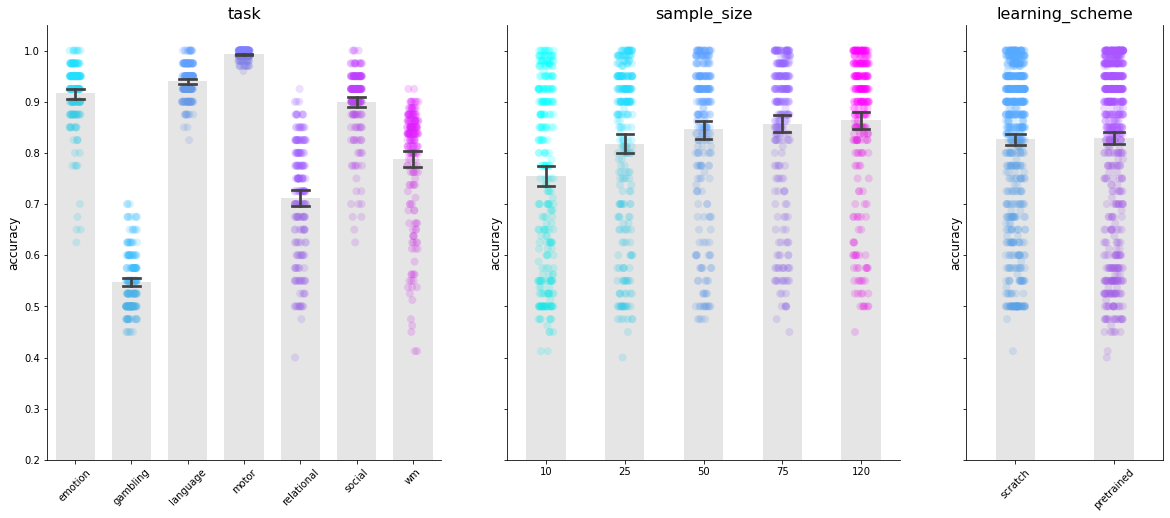

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True, gridspec_kw={'width_ratios': [1, 1, .5]})

# 1. main effect: task
x = 'task'

axes[0].set_xlim([.5, 2.5])
sns.barplot(ax=axes[0], x=x, y="acc", data=full, color=[.5,.5,.5], alpha=.2, errorbar=("ci", 95), capsize=.3, width=.7)
sns.stripplot(ax=axes[0], x=x, y="acc", data=full, hue=x, zorder=1, alpha=.2, size=8, palette="cool", legend=False)
axes[0].set_title(x);
axes[0].set_xticklabels(sorted(left_out_tasks), rotation=45);
axes[0].set(xlabel=None, ylabel="accuracy");
axes[0].set_ylim([.2, 1.05])
axes[0].spines['top'].set_visible(False), axes[0].spines['right'].set_visible(False)

# 2. main effect: training sample size
x = 'sample_size'

axes[1].set_xlim([.5, 2.5])
sns.barplot(ax=axes[1], x=x, y="acc", data=full, color=[.5,.5,.5], alpha=.2, errorbar=("ci", 95), capsize=.2, width=.5)
sns.stripplot(ax=axes[1], x=x, y="acc", data=full, hue=x, zorder=1, alpha=.2, size=8, palette="cool", legend=False)
axes[1].set_title(x);
axes[1].set(xlabel=None, ylabel="accuracy");
axes[1].set_ylim([.2, 1.05])
axes[1].spines['top'].set_visible(False), axes[1].spines['right'].set_visible(False)

# 3. main effect: learning approach
x = 'learning_scheme'

axes[2].set_xlim([.5, 2.5])
sns.barplot(ax=axes[2], x=x, y="acc", data=full, color=[.5,.5,.5], alpha=.2, errorbar=("ci", 95), capsize=.2, width=.4)
sns.stripplot(ax=axes[2], x=x, y="acc", data=full, hue=x, zorder=1, alpha=.2, size=8, palette="cool", legend=False)
axes[2].set_title(x);
axes[2].set_xticklabels(training_approach, rotation=45)
axes[2].set(xlabel=None, ylabel="accuracy");
axes[2].set_ylim([.2, 1.05])
axes[2].spines['top'].set_visible(False), axes[1].spines['right'].set_visible(False);

<AxesSubplot:xlabel='sample_size', ylabel='acc'>

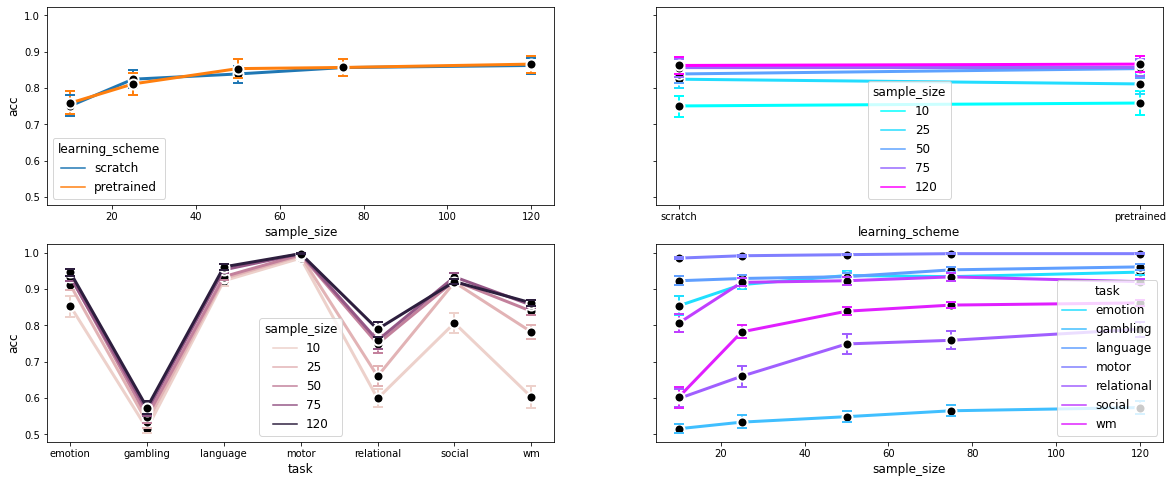

In [39]:
# 2-way interaction plots
fig, axes = plt.subplots(2, 2, figsize=(20,8), sharey=True)
sns.lineplot(data=full, x='sample_size', y="acc", hue='learning_scheme', ax=axes[0,0], 
             marker='o', linewidth=3, markeredgewidth=2, markeredgecolor='white', markerfacecolor='black', markersize=10, errorbar=("ci", 95), 
             err_style="bars", err_kws={'capsize': 5, 'elinewidth': 2, 'capthick': 2})
sns.lineplot(data=full, x='learning_scheme', y="acc", hue='sample_size', ax=axes[0,1], 
             marker='o', linewidth=3, markeredgewidth=2, markeredgecolor='white', markerfacecolor='black', markersize=10, errorbar=("ci", 95), 
             err_style="bars", err_kws={'capsize': 5, 'elinewidth': 2, 'capthick': 2}, palette="cool")

sns.lineplot(data=full, x='task', y="acc", hue='sample_size', ax=axes[1,0], 
             marker='o', linewidth=3, markeredgewidth=2, markeredgecolor='white', markerfacecolor='black', markersize=10, errorbar=("ci", 95), 
             err_style="bars", err_kws={'capsize': 5, 'elinewidth': 2, 'capthick': 2})
sns.lineplot(data=full, x='sample_size', y="acc", hue='task', ax=axes[1,1], 
             marker='o', linewidth=3, markeredgewidth=2, markeredgecolor='white', markerfacecolor='black', markersize=10, errorbar=("ci", 95), 
             err_style="bars", err_kws={'capsize': 5, 'elinewidth': 2, 'capthick': 2}, palette="cool")


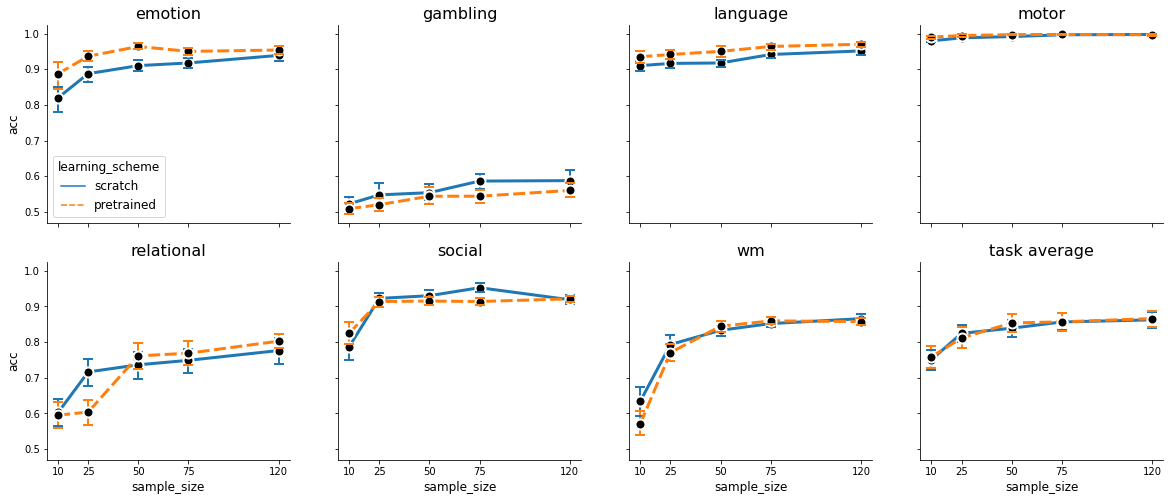

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for i, ax, in enumerate(fig.axes[:-1]):
    if i == 0:
        plt_legend=True
    else:
        plt_legend=False
    
    sns.lineplot(ax=ax, data=full[full.task==target_task[i]], x='sample_size', y="acc", hue='learning_scheme', style='learning_scheme',
                marker='o', linewidth=3, markeredgewidth=2, markeredgecolor='white', markerfacecolor='black', markersize=10, errorbar=("ci", 95),
                err_style="bars", err_kws={'capsize': 5, 'elinewidth': 2, 'capthick': 2}, legend=plt_legend)
    
    ax.spines['top'].set_visible(False), ax.spines['right'].set_visible(False);
    ax.set_title(target_task[i])
    
sns.lineplot(ax=fig.axes[-1], data=full, y='acc', x='sample_size', hue='learning_scheme', style='learning_scheme', 
            marker='o', linewidth=3, markeredgewidth=2, markeredgecolor='white', markerfacecolor='black', markersize=10,
            err_style="bars", err_kws={'capsize': 5, 'elinewidth': 2, 'capthick': 2}, legend=plt_legend, errorbar=("ci", 95))
fig.axes[-1].set_xticks(sample_sizes)
fig.axes[-1].spines['top'].set_visible(False), fig.axes[-1].spines['right'].set_visible(False);
fig.axes[-1].set_title('task average');